In [1]:
from utils.ifa_meander_project_v2.geometry import *
from utils.ifa_meander_project_v2.meshing import *
from utils.ifa_meander_project_v2.frequency import *
from utils.ifa_meander_project_v2.simulation import *

fC      = 868e6  # fréquence centrale en Hz
delta_f = 4e6  # écart entre les échantillons en Hz
print(f"delta_f = {delta_f/1e6:.2f} MHz")
nPoints = 31     # nombre d'échantillons

fLow, fHigh, frequencies = calc_frequencies(fC, delta_f, nPoints)
print(f"fLow = {fLow/1e6:.2f} MHz, fHigh = {fHigh/1e6:.2f} MHz, nPoints = {nPoints}")

In [2]:
""" fC      = 868e6
fLow    = 700e6
fHigh   = 1000e6

nPoints = calculate_nPoints(fLow, fHigh, fC, 80)
accuracy= 0.01
print(f"nPoints = {nPoints}")
frequencies = np.linspace(fLow, fHigh, nPoints)
fc_index = np.where(frequencies == fC)[0][0]
print(f"fc_index = {fc_index}") """

fLow = 700e6
fHigh = 1000e6
fC = 868e6
step = 4e6

frequencies, fc_index, nPoints = generate_frequencies(fLow, fHigh, fC, step)

print(f"Nombre de fréquences (nPoints) : {nPoints}")
print(f"Index de fC : {fc_index}")



Nombre de fréquences (nPoints) : 76
Index de fC : 42


In [3]:
mesh_name = "ifa_meander.msh"
save_mesh_folder = 'data/gmsh_files/'
ifa_meander_mat = 'data/antennas_mesh/ifa_meander.mat'
ifa_meander_msh = save_mesh_folder + mesh_name

In [4]:
a = 25 / 1000  # Largeur
b = 45 / 1000  # Hauteur

terminal_a = 55 / 1000
terminal_b = b
x_t = np.array([-terminal_a, 0, 0, -terminal_a])
y_t = np.array([terminal_b, terminal_b, 0, 0])

# On fixe le short feed et la largur de piste
largeur_piste    = a / 5          # Valeur Minimale    
distance_meandre = a / 5          # Valeur choisie en fonction du resulat de analyse_dist_meandre.ipynb
# feed             = 0.5 * b          # Valuer Positionné a la moitié du ground plane -- 25 mm
# feed             = (1/3) * b + (1/3) * a
# feed               = (-1/14) * b + (8/7) * a             # Best so far
# feed = b - 3 * largeur_piste / 2 - 1 / 1000
feed = 0.5 * b
# feed = largeur_piste / 2
feed_point       = [0, feed, 0]      # On alimente au short feed
mesh_size = 4 * largeur_piste

# Affichage des valeurs
print(f"largeur_piste = {largeur_piste * 1000:.2f} mm")
print(f"distance_meandre = {distance_meandre * 1000:.2f} mm")
print(f"feed = {feed * 1000:.2f} mm")
print(f"mesh_size = {mesh_size * 1000:.2f}")

largeur_piste = 5.00 mm
distance_meandre = 5.00 mm
feed = 22.50 mm
mesh_size = 20.00


In [5]:
def creation_ifa(largeur, hauteur, width, dist_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size):
    x, y, N, distance_meandre = ifa_creation(largeur, hauteur, width, dist_meandre)
    x_m, y_m = trace_meander(x, y, width)
    feed_wid = width # La largeur de la piste est la meme partout
    feed_x = np.array([0, distance_meandre, distance_meandre, 0])
    feed_y = np.array([feed + feed_wid/2, feed + feed_wid/2, feed -feed_wid/2, feed - feed_wid/2])
    antenna_ifa_meander(x_m, y_m, x_t, y_t, feed_x, feed_y, save_mesh_folder, mesh_name, mesh_size)
    extract_msh_to_mat(ifa_meander_msh, ifa_meander_mat)
    return N, distance_meandre

def plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC=None):
    from matplotlib import pyplot as plt
    frequencies = np.linspace(fLow, fHigh, nPoints)
    frequencies_mhz = np.array(frequencies) / 1e6
    s11_db = np.array(s11_db)

    # Trouver le minimum de S11
    min_index = np.argmin(s11_db)
    f_resonance = frequencies[min_index] / 1e6
    s11_min = s11_db[min_index]

    # Tracé
    fig_size = 7
    Fibonacci = (1 + np.sqrt(5)) / 2
    plt.figure(figsize=(fig_size, fig_size / Fibonacci))
    plt.plot(frequencies_mhz, s11_db, label="S11 (dB)", color='blue')
    plt.plot(f_resonance, s11_min, 'ro', 
            label=f"Résonance: {f_resonance:.2f} MHz (S11={s11_min:.2f} dB)")
    
    if fC:
        fC_mhz = fC / 1e6
        idx_fc = np.argmin(np.abs(frequencies - fC))
        s11_fc = s11_db[idx_fc]
        plt.axvline(fC_mhz, color='green', linestyle='--', 
                   label=f"fC = {fC_mhz:.2f} MHz (S11={s11_fc:.2f} dB)")

    plt.xlabel("Fréquence (MHz)")
    plt.ylabel("S11 (dB)")
    plt.title("Courbe de S11 vs Fréquence")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def adapt_with_ratio_square(distance_meandre, largeur_piste, ratio):
    return distance_meandre / (ratio**2), largeur_piste / (ratio**2)

def adapt_with_ratio_cube(distance_meandre, largeur_piste, ratio):
    return distance_meandre / (ratio**3), largeur_piste / (ratio**3)


------------------------------------------------------Iteration N°1------------------------------------------------------

distance meandres = 5.000 mm

Number of meanders = 2

New distance meandres = 7.500 mm
Largeur de piste ifa = 5.000 mm
position feed = 22.500 mm

Simulation 1/76 | f = 700.00 MHz | S11 = -0.15 dB
Simulation 2/76 | f = 704.00 MHz | S11 = -0.15 dB
Simulation 3/76 | f = 708.00 MHz | S11 = -0.16 dB
Simulation 4/76 | f = 712.00 MHz | S11 = -0.17 dB
Simulation 5/76 | f = 716.00 MHz | S11 = -0.17 dB
Simulation 6/76 | f = 720.00 MHz | S11 = -0.18 dB
Simulation 7/76 | f = 724.00 MHz | S11 = -0.19 dB
Simulation 8/76 | f = 728.00 MHz | S11 = -0.20 dB
Simulation 9/76 | f = 732.00 MHz | S11 = -0.20 dB
Simulation 10/76 | f = 736.00 MHz | S11 = -0.21 dB
Simulation 11/76 | f = 740.00 MHz | S11 = -0.22 dB
Simulation 12/76 | f = 744.00 MHz | S11 = -0.23 dB
Simulation 13/76 | f = 748.00 MHz | S11 = -0.24 dB
Simulation 14/76 | f = 752.00 MHz | S11 = -0.25 dB
Simulation 15/76 | f = 75

Simulation 43/76 | f = 868.00 MHz | S11 = -0.85 dB
Simulation 44/76 | f = 872.00 MHz | S11 = -0.89 dB
Simulation 45/76 | f = 876.00 MHz | S11 = -0.93 dB
Simulation 46/76 | f = 880.00 MHz | S11 = -0.97 dB
Simulation 47/76 | f = 884.00 MHz | S11 = -1.02 dB
Simulation 48/76 | f = 888.00 MHz | S11 = -1.07 dB
Simulation 49/76 | f = 892.00 MHz | S11 = -1.12 dB
Simulation 50/76 | f = 896.00 MHz | S11 = -1.18 dB
Simulation 51/76 | f = 900.00 MHz | S11 = -1.24 dB
Simulation 52/76 | f = 904.00 MHz | S11 = -1.30 dB
Simulation 53/76 | f = 908.00 MHz | S11 = -1.37 dB
Simulation 54/76 | f = 912.00 MHz | S11 = -1.44 dB
Simulation 55/76 | f = 916.00 MHz | S11 = -1.51 dB
Simulation 56/76 | f = 920.00 MHz | S11 = -1.59 dB
Simulation 57/76 | f = 924.00 MHz | S11 = -1.67 dB
Simulation 58/76 | f = 928.00 MHz | S11 = -1.76 dB
Simulation 59/76 | f = 932.00 MHz | S11 = -1.86 dB
Simulation 60/76 | f = 936.00 MHz | S11 = -1.96 dB
Simulation 61/76 | f = 940.00 MHz | S11 = -2.06 dB
Simulation 62/76 | f = 944.00 M

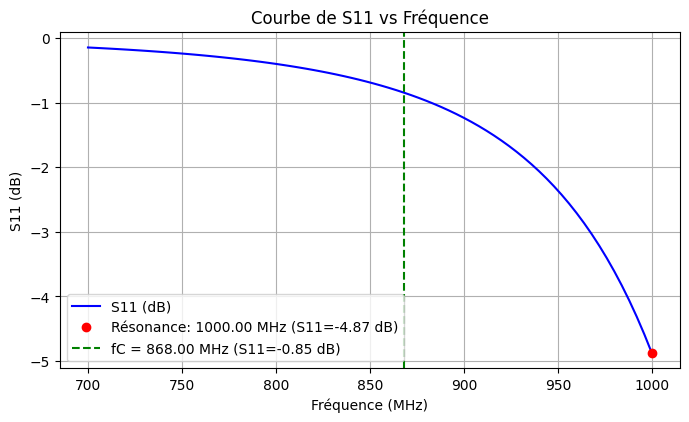


Ratio = 1.152073732718894


We are FAR of fc!


------------------------------------------------------Iteration N°2------------------------------------------------------

distance meandres = 3.767 mm

Number of meanders = 3

New distance meandres = 4.566 mm
Largeur de piste ifa = 3.767 mm
position feed = 22.500 mm

Simulation 1/76 | f = 700.00 MHz | S11 = -0.36 dB
Simulation 2/76 | f = 704.00 MHz | S11 = -0.38 dB
Simulation 3/76 | f = 708.00 MHz | S11 = -0.41 dB
Simulation 4/76 | f = 712.00 MHz | S11 = -0.43 dB
Simulation 5/76 | f = 716.00 MHz | S11 = -0.46 dB
Simulation 6/76 | f = 720.00 MHz | S11 = -0.49 dB
Simulation 7/76 | f = 724.00 MHz | S11 = -0.53 dB
Simulation 8/76 | f = 728.00 MHz | S11 = -0.56 dB
Simulation 9/76 | f = 732.00 MHz | S11 = -0.60 dB
Simulation 10/76 | f = 736.00 MHz | S11 = -0.64 dB
Simulation 11/76 | f = 740.00 MHz | S11 = -0.69 dB
Simulation 12/76 | f = 744.00 MHz | S11 = -0.74 dB
Simulation 13/76 | f = 748.00 MHz | S11 = -0.79 dB
Simulation 14/76 | f = 752.0

Simulation 43/76 | f = 868.00 MHz | S11 = -17.14 dB
Simulation 44/76 | f = 872.00 MHz | S11 = -18.55 dB
Simulation 45/76 | f = 876.00 MHz | S11 = -18.10 dB
Simulation 46/76 | f = 880.00 MHz | S11 = -16.26 dB
Simulation 47/76 | f = 884.00 MHz | S11 = -14.21 dB
Simulation 48/76 | f = 888.00 MHz | S11 = -12.39 dB
Simulation 49/76 | f = 892.00 MHz | S11 = -10.86 dB
Simulation 50/76 | f = 896.00 MHz | S11 = -9.58 dB
Simulation 51/76 | f = 900.00 MHz | S11 = -8.50 dB
Simulation 52/76 | f = 904.00 MHz | S11 = -7.59 dB
Simulation 53/76 | f = 908.00 MHz | S11 = -6.82 dB
Simulation 54/76 | f = 912.00 MHz | S11 = -6.15 dB
Simulation 55/76 | f = 916.00 MHz | S11 = -5.57 dB
Simulation 56/76 | f = 920.00 MHz | S11 = -5.06 dB
Simulation 57/76 | f = 924.00 MHz | S11 = -4.62 dB
Simulation 58/76 | f = 928.00 MHz | S11 = -4.23 dB
Simulation 59/76 | f = 932.00 MHz | S11 = -3.88 dB
Simulation 60/76 | f = 936.00 MHz | S11 = -3.58 dB
Simulation 61/76 | f = 940.00 MHz | S11 = -3.31 dB
Simulation 62/76 | f = 9

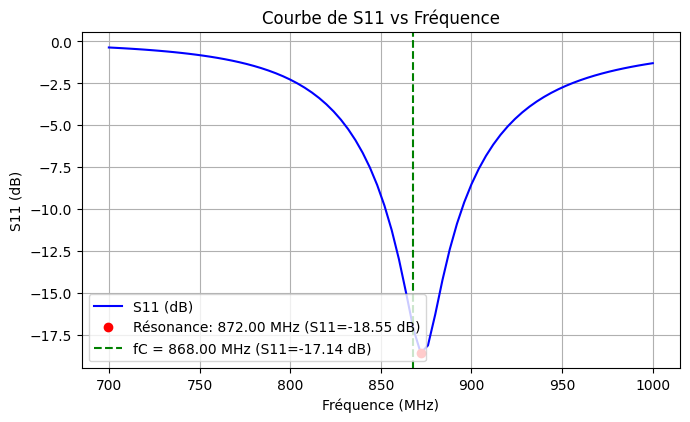


Ratio = 1.0046082949308757


Required Accuracy is met!
Temps de simulation : 0 minutes et 3.07 secondes
Convergence atteinte à l'itération 2


In [6]:
import time
start_time = time.time()
iteration = 1
max_iter = 20
Accuracy = 0.01
converged = False
count = 0
while iteration <= max_iter and not converged:
    try:
        print(f"\n------------------------------------------------------Iteration N°{iteration}------------------------------------------------------\n")
        print(f"distance meandres = {distance_meandre * 1000:.3f} mm\n")
        
        N_list_elem, new_distance_meandre_elem = creation_ifa(a, b, largeur_piste, distance_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size)
        print(f"Number of meanders = {N_list_elem}\n")

        print(f"New distance meandres = {new_distance_meandre_elem * 1000:.3f} mm")
        print(f"Largeur de piste ifa = {largeur_piste * 1000:.3f} mm")
        print(f"position feed = {feed * 1000:.3f} mm\n")

        frequence_resonance, s11_db, R_res, X_res = simulate(frequencies, ifa_meander_mat, fC, feed_point)
        plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC)

        ratio = frequence_resonance / fC
        print(f"\nRatio = {ratio}\n")
        # distance_meandre = distance_meandre / ratio

        if (abs((fC - frequence_resonance)/fC) < Accuracy):
            min_index = np.argmin(s11_db)
            min_s11 = s11_db[min_index]
            s11_fc = s11_db[fc_index]
            if s11_fc < -10 or min_s11 < -20:
                converged = True
                print("\nRequired Accuracy is met!")
                break
            else:
                print("\nOn cherche le matching !!!")

                if ratio == 1:
                    print("Ratio == 1 on modifie le feed parce quon a pas une bonne adaptation")
                    ratio_adapt_feed = math.sqrt(R_res / 50)
                    feed = max(min(feed / ratio_adapt_feed, b - 3 * largeur_piste / 2 - 0.5 / 1000), largeur_piste / 2)
                else:
                    adapt_with_ratio_cube(distance_meandre, largeur_piste, ratio)             # New Addd ---- delete maybe

                    feed = max(min(feed * ratio**2, b - 3 * largeur_piste / 2 - 0.5 / 1000), largeur_piste / 2)

                    print(f"\nresultat feed = {feed * 1000:.3f} mm")

                if feed == b - 3 * largeur_piste / 2 - 0.5 / 1000 or feed == largeur_piste / 2:
                    distance_meandre, largeur_piste = adapt_with_ratio_square(distance_meandre, largeur_piste, ratio)

                feed_point       = [0, feed, 0]

        elif abs(frequence_resonance - fC) < 0.02 * fC:
            print(f"\nWe are within 2% of fc!\n")
            count += 1
            feed = max(min(feed * ratio**2, b - 3 * largeur_piste / 2 - 0.5 / 1000), largeur_piste / 2)

            if feed == b - 3 * largeur_piste / 2 - 0.5 / 1000 or feed == largeur_piste / 2:
                print("\nBord extreme atteint\n")
                distance_meandre, largeur_piste = adapt_with_ratio_square(distance_meandre, largeur_piste, ratio)
            
            feed_point       = [0, feed, 0]
        else:
            print(f"\nWe are FAR of fc!\n")
            distance_meandre, largeur_piste = adapt_with_ratio_square(distance_meandre, largeur_piste, ratio)

            """ # New Add    ---- delete maybe

            feed = max(min(feed * ratio**3, b - 3 * largeur_piste / 2 - 0.5 / 1000), largeur_piste / 2)

            if feed == b - 3 * largeur_piste / 2 - 0.5 / 1000 or feed == largeur_piste / 2:
                print("\nBord extreme atteint\n")
                distance_meandre, largeur_piste = adapt_with_ratio_square(distance_meandre, largeur_piste, ratio)

            # New Add   ---- delete maybe
            
            feed_point       = [0, feed, 0] """

        iteration += 1
    except ValueError as e:
        print(f"Error: {e}")

end_time = time.time()
simulation_time = end_time - start_time
simulation_time_minutes = simulation_time / 60
simulation_time_seconds = simulation_time % 60
print(f"Temps de simulation : {simulation_time_minutes:.0f} minutes et {simulation_time_seconds:.2f} secondes")
if converged:
    print(f"Convergence atteinte à l'itération {iteration}")
else:
    print(f"Convergence non atteinte après {max_iter} itérations")